In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
# new source https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [4]:
req = requests.get(download_link)
rki_raw = pd.read_csv(StringIO(req.text))

In [5]:
rki_raw.tail()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
148368,11495499,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/05/07 00:00:00,16077,"09.06.2020, 00:00 Uhr",0,-9,2020/05/05 00:00:00,0,1,1,Nicht übermittelt
148369,11495500,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2020/05/28 00:00:00,16077,"09.06.2020, 00:00 Uhr",0,-9,2020/05/28 00:00:00,-9,0,0,Nicht übermittelt
148370,11495501,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/05/06 00:00:00,16077,"09.06.2020, 00:00 Uhr",0,-9,2020/05/04 00:00:00,0,1,1,Nicht übermittelt
148371,11495502,16,Thüringen,LK Altenburger Land,A80+,W,1,0,2020/05/11 00:00:00,16077,"09.06.2020, 00:00 Uhr",0,-9,2020/05/01 00:00:00,0,1,1,Nicht übermittelt
148372,11495503,16,Thüringen,LK Altenburger Land,A80+,W,2,0,2020/05/28 00:00:00,16077,"09.06.2020, 00:00 Uhr",0,-9,2020/05/28 00:00:00,-9,0,0,Nicht übermittelt


In [6]:
def new_cases_by_date(rki_raw, rki_flag_column='Neuer Fall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Meldedatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [7]:
rki_cases = new_cases_by_date(rki_raw, rki_flag_column='NeuerFall', rki_count_columns='AnzahlFall')
rki_death = new_cases_by_date(rki_raw, rki_flag_column='NeuerTodesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='NeuGenesen', rki_count_columns='AnzahlGenesen')

In [8]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeathRKI', 'AnzahlGenesen': 'NewRecoveredRKI'}
rki.rename(columns_dict, axis=1, inplace=True)
# using estimates for recovery dates and death dates
shift_recovery = 14 # days
shift_death = 20 # days
rki['NewRecovered'] = rki.NewRecoveredRKI.shift(shift_recovery).fillna(0)
rki['NewDeath'] = rki.NewDeathRKI.shift(shift_death).fillna(0)
s = rki['NewRecoveredRKI'].copy()
s.values[:-shift_recovery] = 0.
rki['NewRecovered'] += s
s = rki['NewDeathRKI'].copy()
s.values[:-shift_death] = 0.
rki['NewDeath'] += s
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeathRKI,NewRecoveredRKI,NewRecovered,NewDeath
Meldedatum,,,,,
2020-06-04,524,3.0,31.0,331.0,27.0
2020-06-05,429,2.0,11.0,417.0,18.0
2020-06-06,270,0.0,3.0,250.0,0.0
2020-06-07,152,0.0,6.0,144.0,0.0
2020-06-08,157,1.0,0.0,0.0,26.0


In [9]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered'] - rki['Death']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeathRKI,NewRecoveredRKI,NewRecovered,NewDeath,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,,,
2020-05-30,370,2.0,65.0,419.0,16.0,181900,8519.0,166988.0,6393.0,0.057876
2020-05-31,181,1.0,24.0,213.0,23.0,182081,8542.0,167201.0,6338.0,0.028558
2020-06-01,138,1.0,11.0,358.0,28.0,182219,8570.0,167559.0,6090.0,0.022660
2020-06-02,301,3.0,40.0,568.0,25.0,182520,8595.0,168127.0,5798.0,0.051914
2020-06-03,491,3.0,34.0,650.0,21.0,183011,8616.0,168777.0,5618.0,0.087398
2020-06-04,524,3.0,31.0,331.0,27.0,183535,8643.0,169108.0,5784.0,0.090595
2020-06-05,429,2.0,11.0,417.0,18.0,183964,8661.0,169525.0,5778.0,0.074247
2020-06-06,270,0.0,3.0,250.0,0.0,184234,8661.0,169775.0,5798.0,0.046568
2020-06-07,152,0.0,6.0,144.0,0.0,184386,8661.0,169919.0,5806.0,0.026180


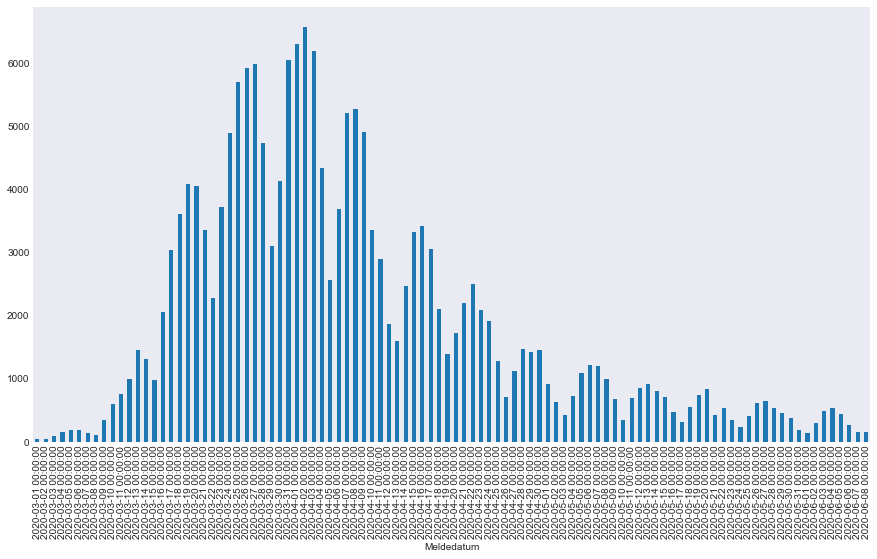

In [10]:
rki.NewCases['03-01-2020':].plot.bar()

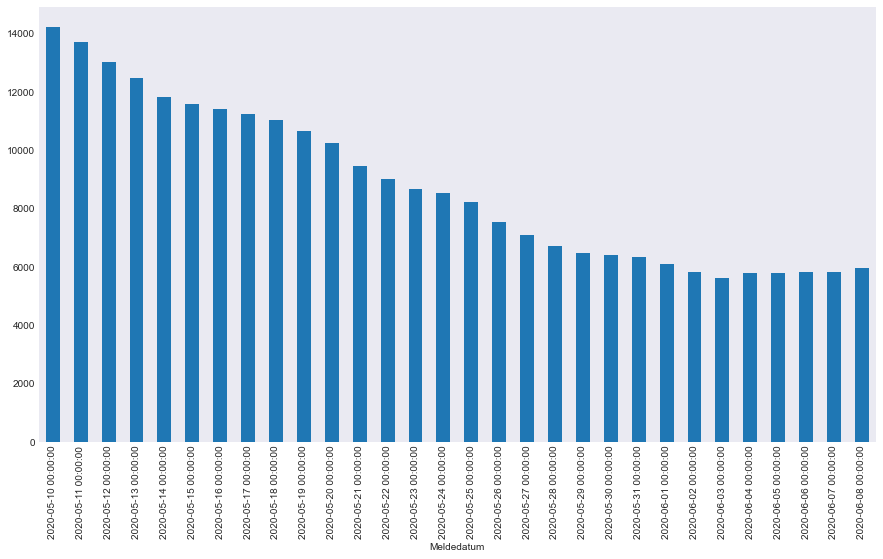

In [11]:
rki.ActiveCases['05-10-2020':].plot.bar()

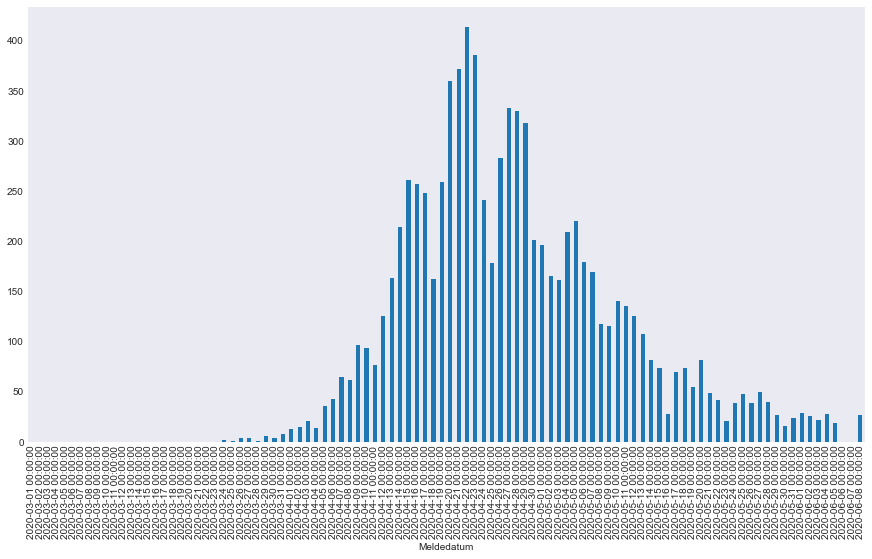

In [12]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

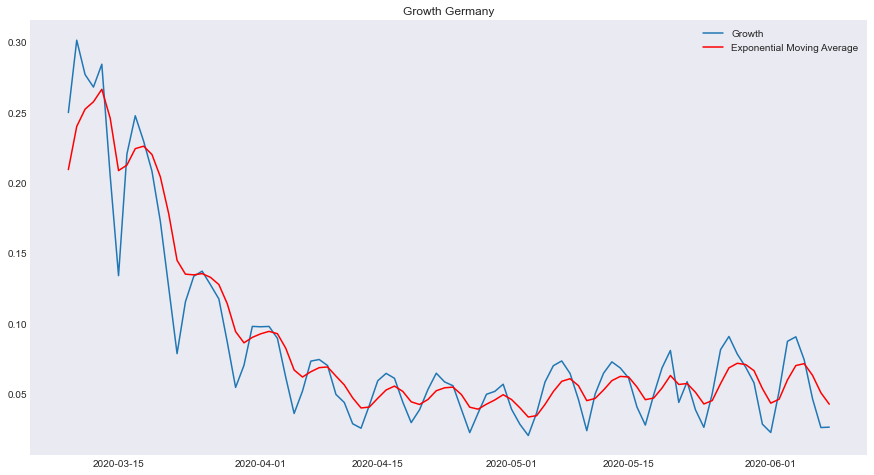

In [13]:
start_date = '03-09-2020'
x = rki[start_date:].index
plt.plot(x, rki.Growth[start_date:], label='Growth')
plt.plot(x, rki.Growth.ewm(span=5,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

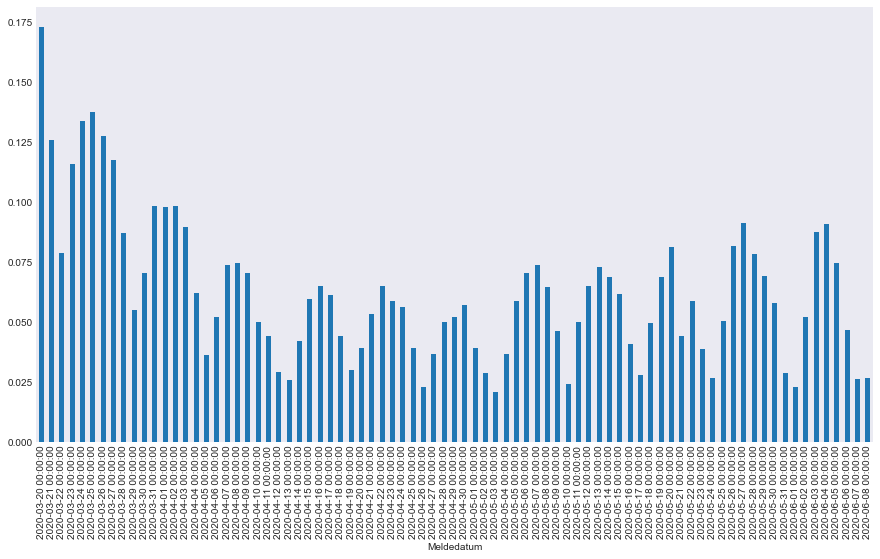

In [14]:
rki.Growth['03-20-2020':].plot.bar()

In [15]:
rki.tail(20)

,NewCases,NewDeathRKI,NewRecoveredRKI,NewRecovered,NewDeath,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,,,
2020-05-20,828,19.0,616.0,1175.0,81.0,177386,8157.0,158993.0,10236.0,0.080891
2020-05-21,416,4.0,300.0,1152.0,48.0,177802,8205.0,160145.0,9452.0,0.044012
2020-05-22,528,9.0,406.0,950.0,41.0,178330,8246.0,161095.0,8989.0,0.058738
2020-05-23,335,5.0,247.0,655.0,20.0,178665,8266.0,161750.0,8649.0,0.038733
2020-05-24,224,3.0,138.0,325.0,38.0,178889,8304.0,162075.0,8510.0,0.026322
2020-05-25,412,7.0,265.0,661.0,47.0,179301,8351.0,162736.0,8214.0,0.050158
2020-05-26,613,6.0,456.0,1270.0,38.0,179914,8389.0,164006.0,7519.0,0.081527
2020-05-27,644,8.0,261.0,1026.0,49.0,180558,8438.0,165032.0,7088.0,0.090858
2020-05-28,526,3.0,188.0,859.0,39.0,181084,8477.0,165891.0,6716.0,0.078320


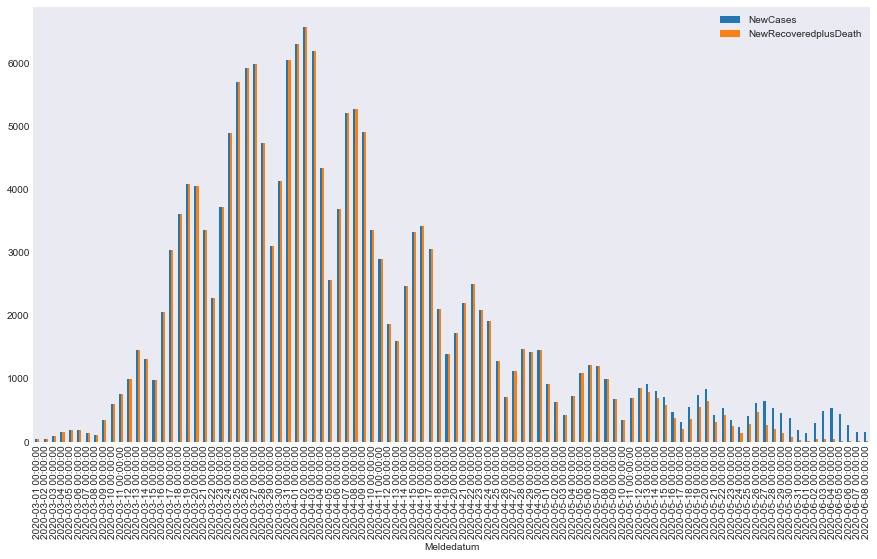

In [16]:
rki['NewRecoveredplusDeath'] = rki.NewRecoveredRKI + rki.NewDeathRKI
rki['03-01-2020':][['NewCases', 'NewRecoveredplusDeath']].plot.bar()
rki.drop('NewRecoveredplusDeath', axis=1, inplace=True)